In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import re
import datetime
import pylab as pl
pl.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sma

In [3]:
def convertDate(d):
    date = datetime.datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p')
    return datetime.date(date.year, date.month, date.day)

In [4]:
complaints = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv', converters={'Created Date': convertDate})

In [5]:
complaints = complaints.rename(columns = {'Created Date': 'Date'})
complaints['dow'] = complaints.apply(lambda x: x['Date'].weekday(), axis=1)

In [10]:
def convertStreak(streak):
    # N is post season?
    #if streak == "N":
    #    return float('Nan')
    sign = -1 if streak and streak[0] == "-" else 1
    return len(streak) * sign

def getDateConverter(year):
    def convertDate(date):
        # Handle duplicate headers
        if date == 'Date':
            return None
        
        # Remove double-header indication (1), (2) and convert to date
        d = datetime.datetime.strptime(re.sub(r'\s\(.*\)', '', date) + ' ' + str(year), '%A %b %d %Y')
        #d.year = year
        return datetime.date(d.year, d.month, d.day)
    
    return convertDate

def convertWL(wl):
    # Covert the W/L column to numeric
    if wl and wl[0] == 'W':
        return 1
    return 0

def readGameLog(csv, convertDate):
    df = pd.read_csv(csv, skip_blank_lines=True, converters={'Streak': convertStreak, 'Date': convertDate, 'W/L': convertWL})
    
    # Remove the headers in the middle of the file and postseason
    df = df.drop(df.index[
        (df.Rk == "Rk") # Drop header rows
    ])
    
    #print [d.days for d in np.diff(df.Date)]
    
    # First game in double headers
    df = df.drop(df.index[(np.append([d.days for d in np.diff(df.Date)], [1]) == 0)])
    
    return df

In [11]:
dfs = []
years = range(2010,2016)
for year in years:
    dfs.append(readGameLog("teams_NYY_%s-schedule-scores_team_schedule.csv" % str(year), getDateConverter(year)))
    
baseball = pd.concat(dfs, ignore_index=True)
baseball['postseason'] = np.isnan(baseball.Rk.astype('float'))

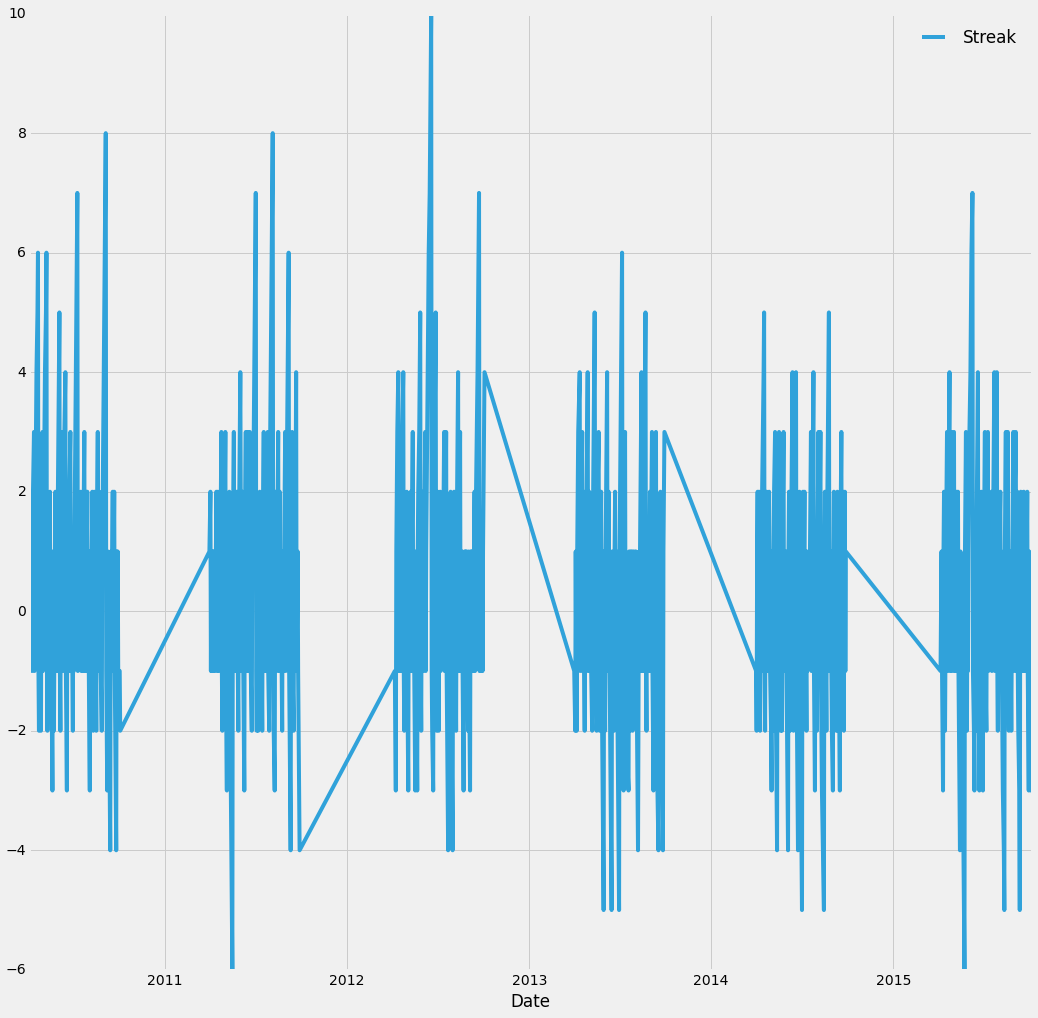

In [12]:
baseball.plot('Date', 'Streak', figsize=(16,16))

In [13]:
complaints = complaints.rename(columns = {'Created Date': 'Date'})

In [14]:
merged = pd.merge(baseball, complaints, on='Date')

In [15]:
grouped = merged.groupby('Date')

In [16]:
streak = []
counts = []
dow = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).Streak.iloc[0])
    dow.append(grouped.get_group(d).dow.iloc[0])
    counts.append(grouped.get_group(d).count()['Date'])

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8440
Date:                Thu, 05 Nov 2015   Prob (F-statistic):              0.358
Time:                        17:38:31   Log-Likelihood:                -8246.2
No. Observations:                 956   AIC:                         1.650e+04
Df Residuals:                     954   BIC:                         1.651e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4439.6886     44.391    100.013      0.0

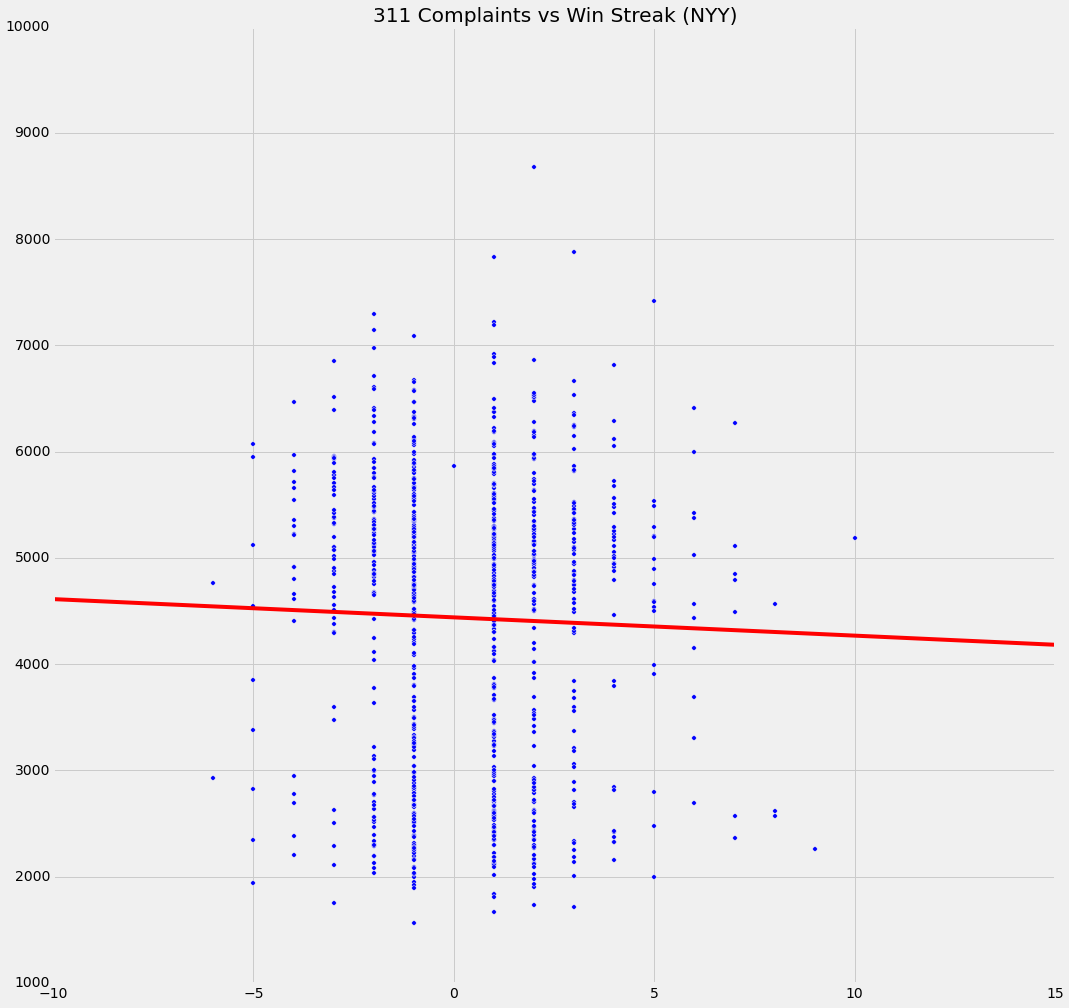

In [17]:
figure, ax = pl.subplots(figsize=(16,16))
ax.scatter(streak, counts)

mod = smf.ols(formula='c ~ s', data = {'c': counts, 's': streak}).fit()
print mod.summary()
abline_plot(model_results=mod, ax=ax, color='red')
ax.set_title('311 Complaints vs Win Streak (NYY)')

In [18]:
mod = smf.ols(formula='c ~ s + C(d)', data = {'c': counts, 's': streak, 'd': dow}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     360.3
Date:                Thu, 05 Nov 2015   Prob (F-statistic):          5.25e-262
Time:                        17:38:52   Log-Likelihood:                -7626.4
No. Observations:                 956   AIC:                         1.527e+04
Df Residuals:                     948   BIC:                         1.531e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5176.5081     69.169     74.839      0.0

In [19]:
noise = merged[merged['Complaint Type'].str.contains('Noise')]

In [20]:
grouped = noise.groupby('Date')

In [21]:
streak = []
counts = []
dow = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).Streak.iloc[0])
    dow.append(grouped.get_group(d).dow.iloc[0])
    counts.append(grouped.get_group(d).count()['Date'])

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.236
Date:                Thu, 05 Nov 2015   Prob (F-statistic):              0.135
Time:                        17:39:26   Log-Likelihood:                -6332.4
No. Observations:                 956   AIC:                         1.267e+04
Df Residuals:                     954   BIC:                         1.268e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    410.6738      5.996     68.491      0.0

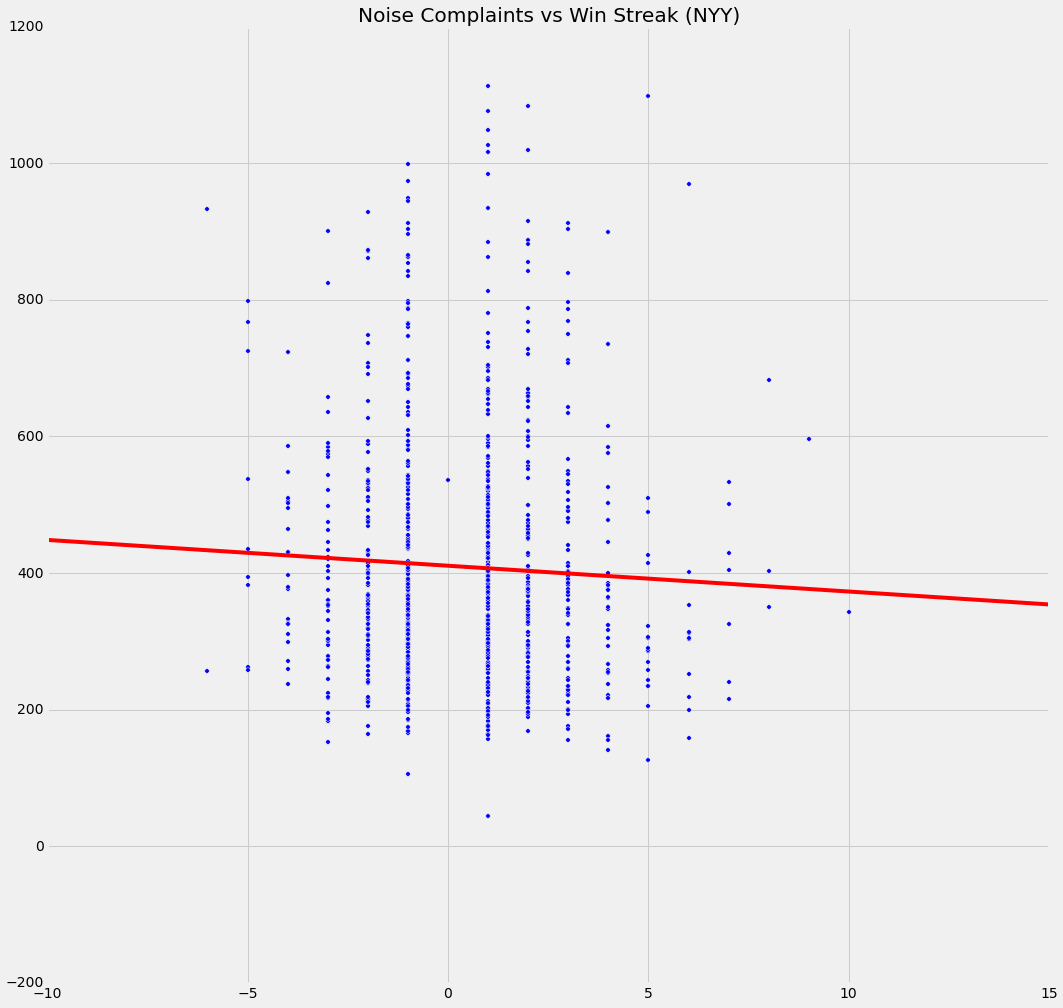

In [22]:
figure, ax = pl.subplots(figsize=(16,16))
ax.scatter(streak, counts)

mod = smf.ols(formula='c ~ s', data = {'c': counts, 's': streak}).fit()
print mod.summary()
abline_plot(model_results=mod, ax=ax, color='red')
ax.set_title('Noise Complaints vs Win Streak (NYY)')

In [24]:
mod = smf.ols(formula='c ~ s + C(d)', data = {'c': counts, 's': streak, 'd': dow}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     42.77
Date:                Thu, 05 Nov 2015   Prob (F-statistic):           1.34e-52
Time:                        17:39:59   Log-Likelihood:                -6202.3
No. Observations:                 956   AIC:                         1.242e+04
Df Residuals:                     948   BIC:                         1.246e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    344.0630     15.594     22.064      0.0

In [25]:
wonoise = merged[~merged['Complaint Type'].str.contains('Noise')]

In [26]:
grouped = wonoise.groupby('Date')

In [27]:
streak = []
counts = []
dow = []
for d in sorted(grouped.groups.keys()):
    streak.append(grouped.get_group(d).Streak.iloc[0])
    dow.append(grouped.get_group(d).dow.iloc[0])
    counts.append(grouped.get_group(d).count()['Date'])

In [28]:
mod = smf.ols(formula='c ~ s + C(d)', data = {'c': counts, 's': streak, 'd': dow}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     456.7
Date:                Thu, 05 Nov 2015   Prob (F-statistic):          1.58e-298
Time:                        17:40:45   Log-Likelihood:                -7580.8
No. Observations:                 956   AIC:                         1.518e+04
Df Residuals:                     948   BIC:                         1.522e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4832.4451     65.946     73.279      0.0

In [29]:
y = []
m = []
years = range(2010,2016)
for year in years:
    y.append(readGameLog("teams_NYY_%s-schedule-scores_team_schedule.csv" % str(year), getDateConverter(year)))
    m.append(readGameLog("teams_NYM_%s-schedule-scores_team_schedule.csv" % str(year), getDateConverter(year)))
    
yankees = pd.concat(y, ignore_index=True)
mets = pd.concat(m, ignore_index=True)

In [30]:
yankees = yankees.rename(columns = {'Streak': 'Yankees_Streak'})

In [31]:
mets = mets.rename(columns = {'Streak': 'Mets_Streak'})

In [32]:
baseball = pd.merge(yankees, mets, on='Date')

In [33]:
baseball.columns

Index([u'Rk_x', u'Gm#_x', u'Date', u'Unnamed: 3_x', u'Tm_x', u'Unnamed: 5_x',
       u'Opp_x', u'W/L_x', u'R_x', u'RA_x', u'Inn_x', u'W-L_x', u'Rank_x',
       u'GB_x', u'Win_x', u'Loss_x', u'Save_x', u'Time_x', u'D/N_x',
       u'Attendance_x', u'Yankees_Streak', u'Rk_y', u'Gm#_y', u'Unnamed: 3_y',
       u'Tm_y', u'Unnamed: 5_y', u'Opp_y', u'W/L_y', u'R_y', u'RA_y', u'Inn_y',
       u'W-L_y', u'Rank_y', u'GB_y', u'Win_y', u'Loss_y', u'Save_y', u'Time_y',
       u'D/N_y', u'Attendance_y', u'Mets_Streak'],
      dtype='object')

In [34]:
merged = pd.merge(baseball, complaints, on='Date')
grouped = merged.groupby('Date')
y_streak = []
m_streak = []
counts = []
dow = []
for d in sorted(grouped.groups.keys()):
    y_streak.append(grouped.get_group(d).Yankees_Streak.iloc[0])
    m_streak.append(grouped.get_group(d).Mets_Streak.iloc[0])
    dow.append(grouped.get_group(d).dow.iloc[0])
    counts.append(grouped.get_group(d).count()['Date'])

In [35]:
mod = smf.ols(formula='c ~ y + m + C(d)', data = {'c': counts, 'y': y_streak, 'm': m_streak, 'd': dow}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     302.4
Date:                Thu, 05 Nov 2015   Prob (F-statistic):          3.03e-245
Time:                        17:47:17   Log-Likelihood:                -7007.4
No. Observations:                 879   AIC:                         1.403e+04
Df Residuals:                     870   BIC:                         1.408e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5021.5987     82.572     60.815      0.0

In [38]:
y_won = np.sign(y_streak)
m_won = np.sign(m_streak)

In [39]:
mod = smf.ols(formula='c ~ C(y) + C(m) + C(d)', data = {'c': counts, 'y': y_won, 'm': m_won, 'd': dow}).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                      c   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     300.0
Date:                Thu, 05 Nov 2015   Prob (F-statistic):          4.20e-244
Time:                        17:50:05   Log-Likelihood:                -7010.0
No. Observations:                 879   AIC:                         1.404e+04
Df Residuals:                     870   BIC:                         1.408e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    5012.2159     90.193     55.572      